In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from PIL import Image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import hashlib
from pathlib import Path
import imagehash
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings('ignore')
os.environ["TF_GPU_ALLOCATOR"] = 'cuda_malloc_async'
tf.compat.v1.disable_eager_execution()

# Define the directories for the dataset
data_dir = 'dataset/images'

# Define the image size and number of classes
img_size = (256, 256)

# Define the batch size and number of epochs
batch_size=128
seed = 42

def alpharemover(image):
    if image.mode != 'RGBA':
        return image
    canvas = Image.new('RGBA', image.size, (255,255,255,255))
    canvas.paste(image, mask=image)
    return canvas.convert('RGB')

def with_ztransform_preprocess(hashfunc, hash_size=8):
    def function(path):
        image = alpharemover(Image.open(path))
        image = image.convert("L").resize((hash_size, hash_size), Image.LANCZOS)
        data = image.getdata()
        quantiles = np.arange(100)
        quantiles_values = np.percentile(data, quantiles)
        zdata = (np.interp(data, quantiles_values, quantiles) / 100 * 255).astype(np.uint8)
        image.putdata(zdata)
        return hashfunc(image)
    return function

dhash_z_transformed = with_ztransform_preprocess(imagehash.dhash, hash_size = 8)

def remove_duplicate_images(data_dir):
    hash_dict = {}
    for class_dir in ['ham', 'spam']:
        class_path = Path(data_dir) / class_dir
        for image_path in class_path.iterdir():
            hash = dhash_z_transformed(image_path)
            if hash not in hash_dict:
                # This is a new unique image, so add it to our hash_dict
                hash_dict[hash] = image_path
            else:
                # This image is a duplicate of an existing one, so delete it
                print(f"Removing duplicate image: {image_path}")
                image_path.unlink()

    return hash_dict


# Call the function to remove duplicate images
hash_dict = remove_duplicate_images(data_dir)


2023-05-26 09:19:43.305188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


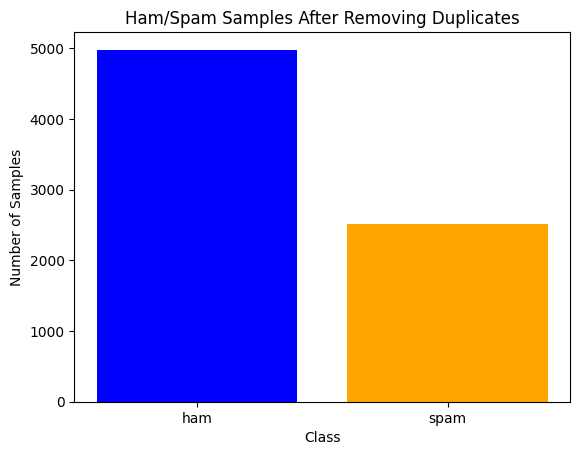

Found 4981 images belonging to 2 classes.
Found 1245 images belonging to 2 classes.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2023-05-26 09:23:00.733603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 09:23:00.736578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 09:23:00.736708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[CV] END batch_size=64, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time=  38.6s


2023-05-26 09:23:39.441578: W tensorflow/c/c_api.cc:300] Operation '{name:'training_2/Adam/dense_3/kernel/v/Assign' id:1013 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/kernel/v, training_2/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:24:14.583579: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:750 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in

[CV] END batch_size=64, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time=  36.4s


2023-05-26 09:24:15.869721: W tensorflow/c/c_api.cc:300] Operation '{name:'total_2/Assign' id:1253 op device:{requested: '', assigned: ''} def:{{{node total_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_2, total_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:24:57.367341: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_2/mul' id:1305 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=64, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time=  42.8s


2023-05-26 09:24:58.652474: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_10/kernel/Assign' id:1707 op device:{requested: '', assigned: ''} def:{{{node conv2d_10/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_10/kernel, conv2d_10/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:25:24.203322: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_3/mul' id:1860 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after

[CV] END batch_size=64, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time=  26.8s


2023-05-26 09:25:25.502928: W tensorflow/c/c_api.cc:300] Operation '{name:'training_8/Adam/conv2d_13/bias/m/Assign' id:2593 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/conv2d_13/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/conv2d_13/bias/m, training_8/Adam/conv2d_13/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:26:06.867659: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_4/mul' id:2415 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_9_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error i

[CV] END batch_size=64, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time=  42.9s


2023-05-26 09:26:08.440891: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_16/bias/Assign' id:2822 op device:{requested: '', assigned: ''} def:{{{node conv2d_16/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_16/bias, conv2d_16/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:26:53.559525: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_5/mul' id:2970 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/dense_11_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

[CV] END batch_size=64, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time=  46.5s


2023-05-26 09:26:54.989778: W tensorflow/c/c_api.cc:300] Operation '{name:'training_12/Adam/dense_13/kernel/m/Assign' id:3732 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_13/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_13/kernel/m, training_12/Adam/dense_13/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:27:34.419077: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:3525 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_13_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger a

[CV] END batch_size=64, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time=  40.8s


2023-05-26 09:27:35.843919: W tensorflow/c/c_api.cc:300] Operation '{name:'training_14/Adam/conv2d_21/bias/m/Assign' id:4246 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/conv2d_21/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/conv2d_21/bias/m, training_14/Adam/conv2d_21/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:28:22.721686: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_7/mul' id:4080 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

[CV] END batch_size=64, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time=  48.4s


2023-05-26 09:28:24.277273: W tensorflow/c/c_api.cc:300] Operation '{name:'training_16/Adam/conv2d_24/kernel/m/Assign' id:4796 op device:{requested: '', assigned: ''} def:{{{node training_16/Adam/conv2d_24/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_16/Adam/conv2d_24/kernel/m, training_16/Adam/conv2d_24/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:28:58.411889: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:4635 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/dense_17_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

[CV] END batch_size=64, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time=  35.9s


2023-05-26 09:29:00.177407: W tensorflow/c/c_api.cc:300] Operation '{name:'total_9/Assign' id:5138 op device:{requested: '', assigned: ''} def:{{{node total_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_9, total_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:29:35.860283: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_9/mul' id:5190 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=64, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time=  37.1s


2023-05-26 09:29:37.345034: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_20/bias/Assign' id:5649 op device:{requested: '', assigned: ''} def:{{{node dense_20/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_20/bias, dense_20/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:30:49.665914: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_10/mul' id:5745 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/dense_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

[CV] END batch_size=64, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.2min


2023-05-26 09:30:51.496741: W tensorflow/c/c_api.cc:300] Operation '{name:'training_22/Adam/iter/Assign' id:6436 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_22/Adam/iter, training_22/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:32:05.220800: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_11/mul' id:6300 op device:{requested: '', assigned: ''} def:{{{node loss_11/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_11/mul/x, loss_11/dense_23_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes

[CV] END batch_size=64, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 09:32:07.006570: W tensorflow/c/c_api.cc:300] Operation '{name:'training_24/Adam/conv2d_38/bias/v/Assign' id:7101 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/conv2d_38/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/conv2d_38/bias/v, training_24/Adam/conv2d_38/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:32:49.314120: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_12/mul' id:6855 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_25_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger a

[CV] END batch_size=64, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time=  44.2s


2023-05-26 09:32:51.088446: W tensorflow/c/c_api.cc:300] Operation '{name:'training_26/Adam/dense_26/kernel/m/Assign' id:7607 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/dense_26/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/dense_26/kernel/m, training_26/Adam/dense_26/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:33:32.925814: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_13/mul' id:7410 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_27_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

[CV] END batch_size=64, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time=  43.6s


2023-05-26 09:33:34.682552: W tensorflow/c/c_api.cc:300] Operation '{name:'count_14/Assign' id:7918 op device:{requested: '', assigned: ''} def:{{{node count_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_14, count_14/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:34:45.874779: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_14/mul' id:7965 op device:{requested: '', assigned: ''} def:{{{node loss_14/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_14/mul/x, loss_14/dense_29_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=64, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.2min


2023-05-26 09:34:47.983351: W tensorflow/c/c_api.cc:300] Operation '{name:'training_30/Adam/conv2d_46/bias/m/Assign' id:8698 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/conv2d_46/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/conv2d_46/bias/m, training_30/Adam/conv2d_46/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:35:34.484516: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_15/mul' id:8520 op device:{requested: '', assigned: ''} def:{{{node loss_15/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul/x, loss_15/dense_31_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger a

[CV] END batch_size=64, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time=  48.3s


2023-05-26 09:35:36.328096: W tensorflow/c/c_api.cc:300] Operation '{name:'training_32/Adam/dense_32/bias/v/Assign' id:9333 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_32/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_32/bias/v, training_32/Adam/dense_32/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:36:19.897434: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_16/mul' id:9075 op device:{requested: '', assigned: ''} def:{{{node loss_16/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_16/mul/x, loss_16/dense_33_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

[CV] END batch_size=64, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time=  45.1s


2023-05-26 09:36:21.438306: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_51/kernel/Assign' id:9452 op device:{requested: '', assigned: ''} def:{{{node conv2d_51/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_51/kernel, conv2d_51/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:37:04.072210: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_17/mul' id:9630 op device:{requested: '', assigned: ''} def:{{{node loss_17/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_17/mul/x, loss_17/dense_35_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes 

[CV] END batch_size=64, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time=  44.7s


2023-05-26 09:37:06.212061: W tensorflow/c/c_api.cc:300] Operation '{name:'training_36/Adam/dense_36/kernel/v/Assign' id:10438 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/dense_36/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/dense_36/kernel/v, training_36/Adam/dense_36/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:39:05.264494: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_18/mul' id:10185 op device:{requested: '', assigned: ''} def:{{{node loss_18/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_18/mul/x, loss_18/dense_37_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tri

[CV] END batch_size=64, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time= 2.0min


2023-05-26 09:39:07.475773: W tensorflow/c/c_api.cc:300] Operation '{name:'training_38/Adam/conv2d_57/kernel/v/Assign' id:10957 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/conv2d_57/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/conv2d_57/kernel/v, training_38/Adam/conv2d_57/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:39:54.336316: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_19/mul' id:10740 op device:{requested: '', assigned: ''} def:{{{node loss_19/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_19/mul/x, loss_19/dense_39_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will

[CV] END batch_size=64, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time=  48.9s


2023-05-26 09:39:56.377231: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_41/bias/Assign' id:11232 op device:{requested: '', assigned: ''} def:{{{node dense_41/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_41/bias, dense_41/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:40:53.685359: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_20/mul' id:11295 op device:{requested: '', assigned: ''} def:{{{node loss_20/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_20/mul/x, loss_20/dense_41_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

[CV] END batch_size=64, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time=  59.5s


2023-05-26 09:40:55.907843: W tensorflow/c/c_api.cc:300] Operation '{name:'training_42/Adam/conv2d_64/bias/m/Assign' id:12028 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/conv2d_64/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/conv2d_64/bias/m, training_42/Adam/conv2d_64/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:42:10.484298: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_21/mul' id:11850 op device:{requested: '', assigned: ''} def:{{{node loss_21/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_21/mul/x, loss_21/dense_43_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

[CV] END batch_size=64, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 09:42:12.741458: W tensorflow/c/c_api.cc:300] Operation '{name:'training_44/Adam/conv2d_68/bias/v/Assign' id:12651 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/conv2d_68/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/conv2d_68/bias/v, training_44/Adam/conv2d_68/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:43:15.895816: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_22/mul' id:12405 op device:{requested: '', assigned: ''} def:{{{node loss_22/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_22/mul/x, loss_22/dense_45_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

[CV] END batch_size=64, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.1min


2023-05-26 09:43:18.174687: W tensorflow/c/c_api.cc:300] Operation '{name:'training_46/Adam/dense_46/bias/m/Assign' id:13162 op device:{requested: '', assigned: ''} def:{{{node training_46/Adam/dense_46/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_46/Adam/dense_46/bias/m, training_46/Adam/dense_46/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:44:15.571668: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_23/mul' id:12960 op device:{requested: '', assigned: ''} def:{{{node loss_23/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_23/mul/x, loss_23/dense_47_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an 

[CV] END batch_size=64, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time=  59.7s


2023-05-26 09:44:17.879093: W tensorflow/c/c_api.cc:300] Operation '{name:'training_48/Adam/dense_49/bias/m/Assign' id:13727 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/dense_49/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/dense_49/bias/m, training_48/Adam/dense_49/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:46:11.247950: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_24/mul' id:13515 op device:{requested: '', assigned: ''} def:{{{node loss_24/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_24/mul/x, loss_24/dense_49_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an 

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.9min


2023-05-26 09:46:13.656291: W tensorflow/c/c_api.cc:300] Operation '{name:'training_50/Adam/dense_51/kernel/m/Assign' id:14277 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/dense_51/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/dense_51/kernel/m, training_50/Adam/dense_51/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:47:40.421875: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_25/mul' id:14070 op device:{requested: '', assigned: ''} def:{{{node loss_25/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_25/mul/x, loss_25/dense_51_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tri

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.5min


2023-05-26 09:47:42.884232: W tensorflow/c/c_api.cc:300] Operation '{name:'training_52/Adam/dense_53/kernel/v/Assign' id:14888 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/dense_53/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/dense_53/kernel/v, training_52/Adam/dense_53/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:48:52.541071: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_26/mul' id:14625 op device:{requested: '', assigned: ''} def:{{{node loss_26/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_26/mul/x, loss_26/dense_53_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tri

[CV] END batch_size=128, dropout_rate=0.2, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.2min


2023-05-26 09:48:54.891923: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_82/kernel/Assign' id:15027 op device:{requested: '', assigned: ''} def:{{{node conv2d_82/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_82/kernel, conv2d_82/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:49:58.520205: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_27/mul' id:15180 op device:{requested: '', assigned: ''} def:{{{node loss_27/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_27/mul/x, loss_27/dense_55_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node

[CV] END batch_size=128, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.1min


2023-05-26 09:50:01.128414: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_86/kernel/Assign' id:15607 op device:{requested: '', assigned: ''} def:{{{node conv2d_86/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_86/kernel, conv2d_86/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:51:24.872913: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_28/mul' id:15735 op device:{requested: '', assigned: ''} def:{{{node loss_28/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_28/mul/x, loss_28/dense_57_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node

[CV] END batch_size=128, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.4min


2023-05-26 09:51:27.308216: W tensorflow/c/c_api.cc:300] Operation '{name:'training_58/Adam/conv2d_89/bias/v/Assign' id:16536 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/conv2d_89/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/conv2d_89/bias/v, training_58/Adam/conv2d_89/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:52:19.842568: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_29/mul' id:16290 op device:{requested: '', assigned: ''} def:{{{node loss_29/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_29/mul/x, loss_29/dense_59_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger

[CV] END batch_size=128, dropout_rate=0.2, epochs=80, learning_rate=0.001, optimizer=adam; total time=  55.0s


2023-05-26 09:52:22.288233: W tensorflow/c/c_api.cc:300] Operation '{name:'training_60/Adam/beta_2/Assign' id:16991 op device:{requested: '', assigned: ''} def:{{{node training_60/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_60/Adam/beta_2, training_60/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:53:40.486649: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_30/mul' id:16845 op device:{requested: '', assigned: ''} def:{{{node loss_30/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_30/mul/x, loss_30/dense_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either 

[CV] END batch_size=128, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 09:53:42.930953: W tensorflow/c/c_api.cc:300] Operation '{name:'training_62/Adam/beta_2/Assign' id:17546 op device:{requested: '', assigned: ''} def:{{{node training_62/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_62/Adam/beta_2, training_62/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:55:32.885935: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_31/mul' id:17400 op device:{requested: '', assigned: ''} def:{{{node loss_31/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_31/mul/x, loss_31/dense_63_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either 

[CV] END batch_size=128, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.9min


2023-05-26 09:55:35.365004: W tensorflow/c/c_api.cc:300] Operation '{name:'training_64/Adam/dense_65/bias/v/Assign' id:18223 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/dense_65/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/dense_65/bias/v, training_64/Adam/dense_65/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:56:50.872884: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_32/mul' id:17955 op device:{requested: '', assigned: ''} def:{{{node loss_32/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_32/mul/x, loss_32/dense_65_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an 

[CV] END batch_size=128, dropout_rate=0.3, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 09:56:53.411734: W tensorflow/c/c_api.cc:300] Operation '{name:'training_66/Adam/iter/Assign' id:18646 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_66/Adam/iter, training_66/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:58:34.822712: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_33/mul' id:18510 op device:{requested: '', assigned: ''} def:{{{node loss_33/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_33/mul/x, loss_33/dense_67_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nod

[CV] END batch_size=128, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.7min


2023-05-26 09:58:37.357973: W tensorflow/c/c_api.cc:300] Operation '{name:'training_68/Adam/dense_68/kernel/m/Assign' id:19262 op device:{requested: '', assigned: ''} def:{{{node training_68/Adam/dense_68/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_68/Adam/dense_68/kernel/m, training_68/Adam/dense_68/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 09:59:56.163439: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_34/mul' id:19065 op device:{requested: '', assigned: ''} def:{{{node loss_34/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_34/mul/x, loss_34/dense_69_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tri

[CV] END batch_size=128, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.4min


2023-05-26 09:59:58.724830: W tensorflow/c/c_api.cc:300] Operation '{name:'training_70/Adam/decay/Assign' id:19771 op device:{requested: '', assigned: ''} def:{{{node training_70/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_70/Adam/decay, training_70/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:01:11.530651: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_35/mul' id:19620 op device:{requested: '', assigned: ''} def:{{{node loss_35/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_35/mul/x, loss_35/dense_71_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don'

[CV] END batch_size=128, dropout_rate=0.3, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 10:01:14.175257: W tensorflow/c/c_api.cc:300] Operation '{name:'training_72/Adam/conv2d_108/kernel/m/Assign' id:20336 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/conv2d_108/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/conv2d_108/kernel/m, training_72/Adam/conv2d_108/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:03:01.547527: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_36/mul' id:20175 op device:{requested: '', assigned: ''} def:{{{node loss_36/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_36/mul/x, loss_36/dense_73_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and 

[CV] END batch_size=128, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.8min


2023-05-26 10:03:04.188972: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_75/kernel/Assign' id:20662 op device:{requested: '', assigned: ''} def:{{{node dense_75/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_75/kernel, dense_75/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:04:08.576082: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_37/mul' id:20730 op device:{requested: '', assigned: ''} def:{{{node loss_37/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_37/mul/x, loss_37/dense_75_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af

[CV] END batch_size=128, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.1min


2023-05-26 10:04:11.283354: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_115/kernel/Assign' id:21132 op device:{requested: '', assigned: ''} def:{{{node conv2d_115/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_115/kernel, conv2d_115/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:05:24.021810: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_38/mul' id:21285 op device:{requested: '', assigned: ''} def:{{{node loss_38/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_38/mul/x, loss_38/dense_77_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify 

[CV] END batch_size=128, dropout_rate=0.4, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.3min


2023-05-26 10:05:26.765749: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_117/kernel/Assign' id:21662 op device:{requested: '', assigned: ''} def:{{{node conv2d_117/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_117/kernel, conv2d_117/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:07:02.651352: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_39/mul' id:21840 op device:{requested: '', assigned: ''} def:{{{node loss_39/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_39/mul/x, loss_39/dense_79_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify 

[CV] END batch_size=128, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.6min


2023-05-26 10:07:05.387762: W tensorflow/c/c_api.cc:300] Operation '{name:'training_80/Adam/conv2d_121/kernel/v/Assign' id:22624 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/conv2d_121/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/conv2d_121/kernel/v, training_80/Adam/conv2d_121/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:08:52.386086: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_40/mul' id:22395 op device:{requested: '', assigned: ''} def:{{{node loss_40/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_40/mul/x, loss_40/dense_81_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and 

[CV] END batch_size=128, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.8min


2023-05-26 10:08:55.091724: W tensorflow/c/c_api.cc:300] Operation '{name:'total_41/Assign' id:22898 op device:{requested: '', assigned: ''} def:{{{node total_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_41, total_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:10:13.571069: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_41/mul' id:22950 op device:{requested: '', assigned: ''} def:{{{node loss_41/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_41/mul/x, loss_41/dense_83_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[CV] END batch_size=128, dropout_rate=0.4, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.4min


2023-05-26 10:10:16.338650: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_85/bias/Assign' id:23442 op device:{requested: '', assigned: ''} def:{{{node dense_85/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_85/bias, dense_85/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:11:45.629125: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_42/mul' id:23505 op device:{requested: '', assigned: ''} def:{{{node loss_42/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_42/mul/x, loss_42/dense_85_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

[CV] END batch_size=128, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.5min


2023-05-26 10:11:48.480567: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_129/kernel/Assign' id:23882 op device:{requested: '', assigned: ''} def:{{{node conv2d_129/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_129/kernel, conv2d_129/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:13:18.525314: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_43/mul' id:24060 op device:{requested: '', assigned: ''} def:{{{node loss_43/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_43/mul/x, loss_43/dense_87_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify 

[CV] END batch_size=128, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time= 1.5min


2023-05-26 10:13:21.339167: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_134/bias/Assign' id:24492 op device:{requested: '', assigned: ''} def:{{{node conv2d_134/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_134/bias, conv2d_134/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:15:23.024447: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_44/mul' id:24615 op device:{requested: '', assigned: ''} def:{{{node loss_44/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_44/mul/x, loss_44/dense_89_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or

[CV] END batch_size=128, dropout_rate=0.5, epochs=50, learning_rate=0.001, optimizer=adam; total time= 2.1min


2023-05-26 10:15:25.939651: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_137/bias/Assign' id:25047 op device:{requested: '', assigned: ''} def:{{{node conv2d_137/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_137/bias, conv2d_137/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:16:47.349021: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_45/mul' id:25170 op device:{requested: '', assigned: ''} def:{{{node loss_45/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_45/mul/x, loss_45/dense_91_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or

[CV] END batch_size=128, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.4min


2023-05-26 10:16:50.295756: W tensorflow/c/c_api.cc:300] Operation '{name:'training_92/Adam/conv2d_140/bias/v/Assign' id:25971 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/conv2d_140/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/conv2d_140/bias/v, training_92/Adam/conv2d_140/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:18:43.303357: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_46/mul' id:25725 op device:{requested: '', assigned: ''} def:{{{node loss_46/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_46/mul/x, loss_46/dense_93_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tri

[CV] END batch_size=128, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.9min


2023-05-26 10:18:46.274288: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_94/kernel/Assign' id:26179 op device:{requested: '', assigned: ''} def:{{{node dense_94/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_94/kernel, dense_94/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:20:15.728926: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_47/mul' id:26280 op device:{requested: '', assigned: ''} def:{{{node loss_47/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_47/mul/x, loss_47/dense_95_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af

[CV] END batch_size=128, dropout_rate=0.5, epochs=80, learning_rate=0.001, optimizer=adam; total time= 1.5min


2023-05-26 10:20:18.584382: W tensorflow/c/c_api.cc:300] Operation '{name:'training_96/Adam/conv2d_145/bias/v/Assign' id:27069 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/conv2d_145/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/conv2d_145/bias/v, training_96/Adam/conv2d_145/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Best: 0.8677235841751099 using {'batch_size': 128, 'dropout_rate': 0.5, 'epochs': 80, 'learning_rate': 0.001, 'optimizer': 'adam'}


In [2]:
# Plot graph of the ham/spam samples using bar chart before model build
ham_count = sum(1 for image_hash in hash_dict.values() if "ham" in str(image_hash))
spam_count = sum(1 for image_hash in hash_dict.values() if "spam" in str(image_hash))
plt.bar(["ham", "spam"], [ham_count, spam_count], color=["blue", "orange"])
plt.title("Ham/Spam Samples After Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Create an instance of the ImageDataGenerator class for data augmentation
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # set validation split
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: tf.image.resize_with_pad(x, target_height=img_size[0], target_width=img_size[1]))

# Use flow_from_directory method to load the training dataset
train_data_generator = data_augmentation.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training',
    seed=seed)  # set as training data

# Use flow_from_directory method to load the validation dataset
val_data_generator = data_augmentation.flow_from_directory(
    data_dir, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed)  # set as validation data

# Create a function to build the model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

def build_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Map optimizer name to optimizer class
    optimizers = {
        'sgd': tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    }

    # Get the correct optimizer
    opt = optimizers.get(optimizer)

    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Specify parameters and distributions to sample from
param_grid = {
    'optimizer': ['adam'],
    'learning_rate': [0.001],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'batch_size': [64, 128],
    'epochs': [50, 80]
}

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()

# Specify callbacks
early_stopping = EarlyStopping(monitor='loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
callbacks = [early_stopping]

# Build the KerasClassifier
keras_clf = KerasClassifier(build_fn=build_model, callbacks=callbacks, verbose=0)

# Initialize lists to store the image data and labels
X = []
y = []

# Loop through each sub-directory in the main directory
for dir in os.listdir(data_dir):
    for filename in os.listdir(os.path.join(data_dir, dir)):
        # Load the image and resize it
        img = load_img(os.path.join(data_dir, dir, filename), target_size=img_size)
        # Convert the image to a NumPy array and add a batch dimension
        img = img_to_array(img)
        # Preprocess the image using the mobilenet_v2 preprocessing function
        img = preprocess_input(img)
        # Add the image to the list of images
        X.append(img)
        # Add the label to the list of labels
        y.append(dir)

# Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform the grid search
grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Print results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')


In [3]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit and transform the labels
y = le.fit_transform(y)

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Evaluate the best model on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

2023-05-26 10:22:07.029009: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_48/mul' id:26835 op device:{requested: '', assigned: ''} def:{{{node loss_48/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_48/mul/x, loss_48/dense_97_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Test loss: 0.6157417199720415
Test accuracy: 0.8772515058517456


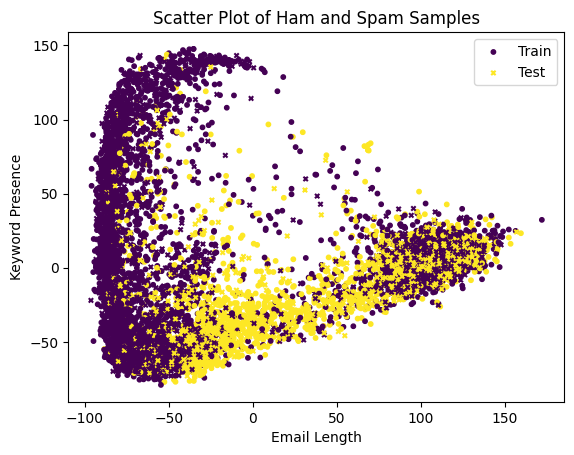

In [23]:
# Now, plot the train and test points with different colors
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Train', s=10)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', label='Test', s=10)

plt.xlabel("Email Length")
plt.ylabel("Keyword Presence")
plt.title("Scatter Plot of Ham and Spam Samples")
plt.legend()
plt.show()

Means: 0.8578810691833496, Stdev: 0.004620537838431706 with: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.8600496451059977, Stdev: 0.007945027103225831 with: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 80, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.8575470646222433, Stdev: 0.00687228896149329 with: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.8638879060745239, Stdev: 0.005861100705488082 with: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 80, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.8590493003527323, Stdev: 0.007776872957933701 with: {'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.8588814735412598, Stdev: 0.007802020857802283 with: {'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 80, 'learning_rate': 0.001, 'optimizer': 'adam'}
Means: 0.864219069480896, Stdev: 0.004819

2023-05-26 10:22:08.782223: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_97/Sigmoid' id:26778 op device:{requested: '', assigned: ''} def:{{{node dense_97/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_97/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


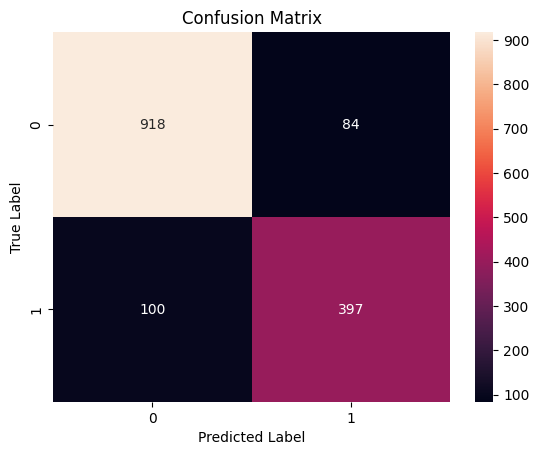

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1002
           1       0.83      0.80      0.81       497

    accuracy                           0.88      1499
   macro avg       0.86      0.86      0.86      1499
weighted avg       0.88      0.88      0.88      1499



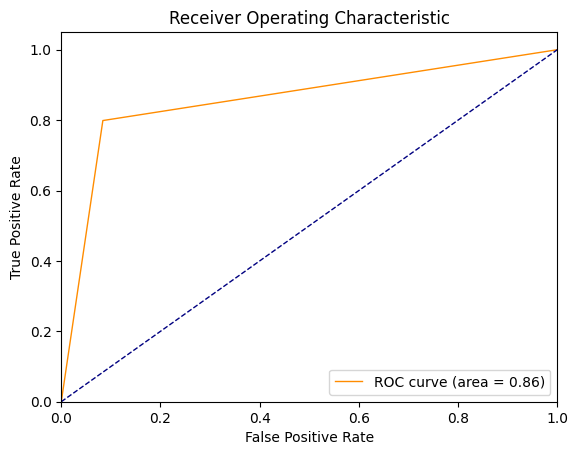

In [4]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

    
# Get the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder and transform y_train and y_test
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Print results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate the best model
score, acc = best_model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

# Predictions
predictions = (best_model.predict(X_test) > 0.5).astype('int32')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_test, predictions))

# ROC Curve and AUC for the test set
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
# Save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model.h5')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder and transform y_train and y_test
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Evaluate the best model on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

Test loss: 0.6157417199720415
Test accuracy: 0.8772515058517456


2023-05-26 10:22:11.507563: W tensorflow/c/c_api.cc:300] Operation '{name:'training_98/Adam/conv2d_149/bias/m/Assign' id:27581 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/conv2d_149/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/conv2d_149/bias/m, training_98/Adam/conv2d_149/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-26 10:24:36.219101: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_99/Sigmoid' id:27334 op device:{requested: '', assigned: ''} def:{{{node dense_99/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_99/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an erro

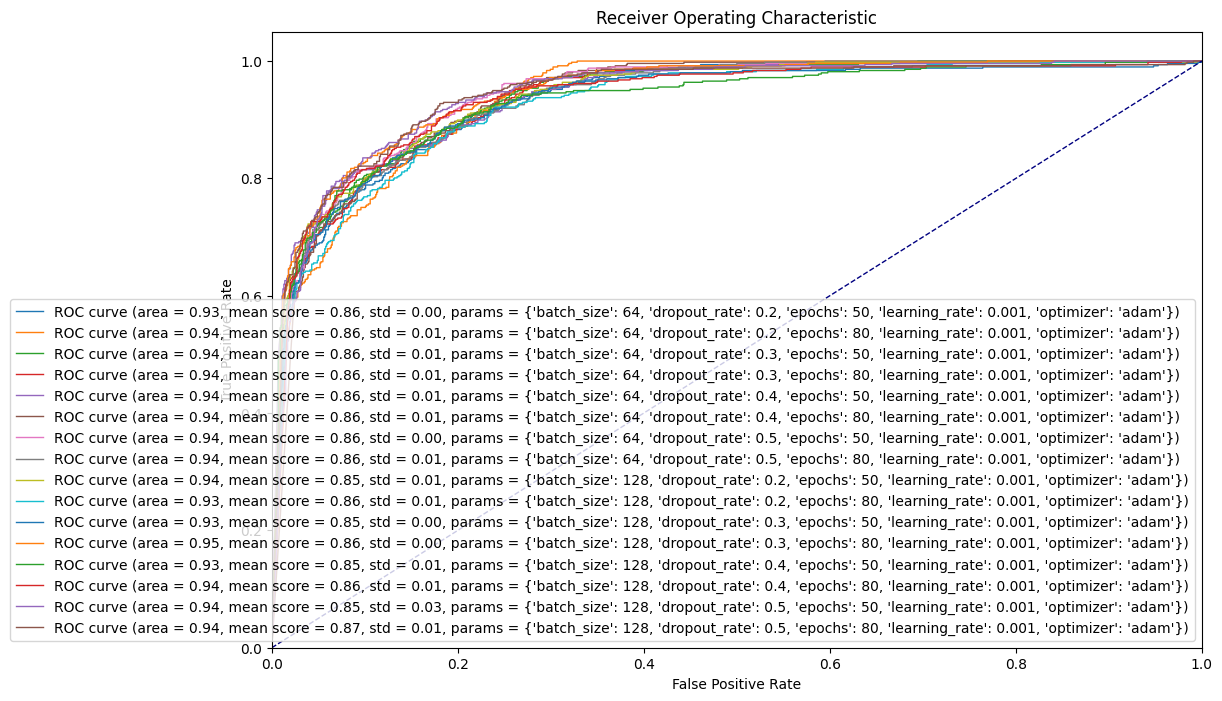

In [6]:
plt.figure(figsize=(12, 8))

# Create a dictionary to store prediction results
prediction_results = {}

# Loop through the GridSearchCV results
for i, params in enumerate(grid_result.cv_results_['params']):
    # Build and train a model with the given parameters
    model = build_model(optimizer=params['optimizer'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    
    # Calculate the ROC curve
    predictions_proba = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)
    
    # Get the mean test score and standard deviation for the current parameters
    mean_score = grid_result.cv_results_['mean_test_score'][i]
    std_score = grid_result.cv_results_['std_test_score'][i]
    
    # Save the results in the dictionary
    prediction_results[i] = {
        'params': params,
        'predictions_proba': predictions_proba,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'mean_score': mean_score,
        'std_score': std_score
    }
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=1, label=f'ROC curve (area = {roc_auc:.2f}, mean score = {mean_score:.2f}, std = {std_score:.2f}, params = {params})')

# Add details to the plot
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



{'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 80, 'learning_rate': 0.001, 'optimizer': 'adam'}
0.9466770683984145


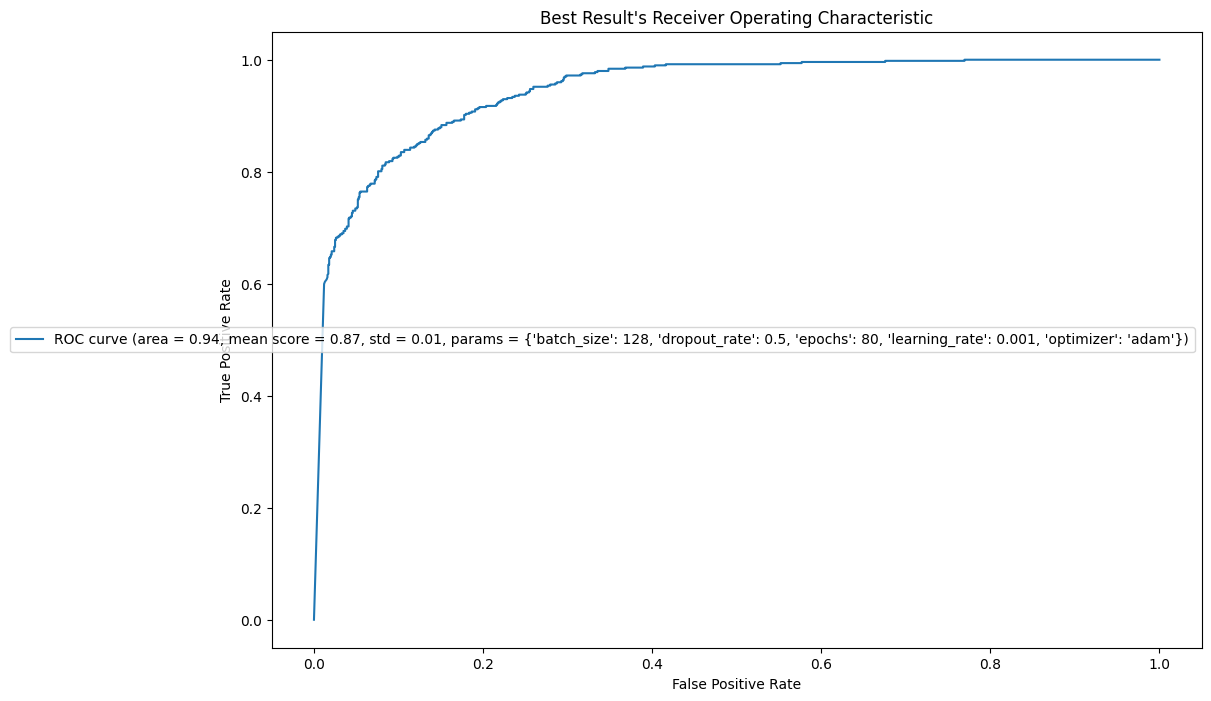

In [7]:
# Sort the results by AUC in descending order
sorted_results = sorted(prediction_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)

# Now, sorted_results is a list of tuples, where the first element of each tuple is the original key from prediction_results,
# and the second element is the corresponding dictionary with prediction results
# The list is sorted by the 'roc_auc' value in the dictionaries

# Example usage:
# Print the parameters of the best model (the one with the highest AUC)
print(sorted_results[0][1]['params'])

# Print the AUC of the best model
print(sorted_results[0][1]['roc_auc'])

# Plot the ROC curve of the best model
plt.figure(figsize=(12,8))
plt.plot(sorted_results[0][1]['fpr'], sorted_results[0][1]['tpr'],label=f'ROC curve (area = {roc_auc:.2f}, mean score = {mean_score:.2f}, std = {std_score:.2f}, params = {params})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Best Result's Receiver Operating Characteristic")
plt.legend(loc="best")
plt.show()


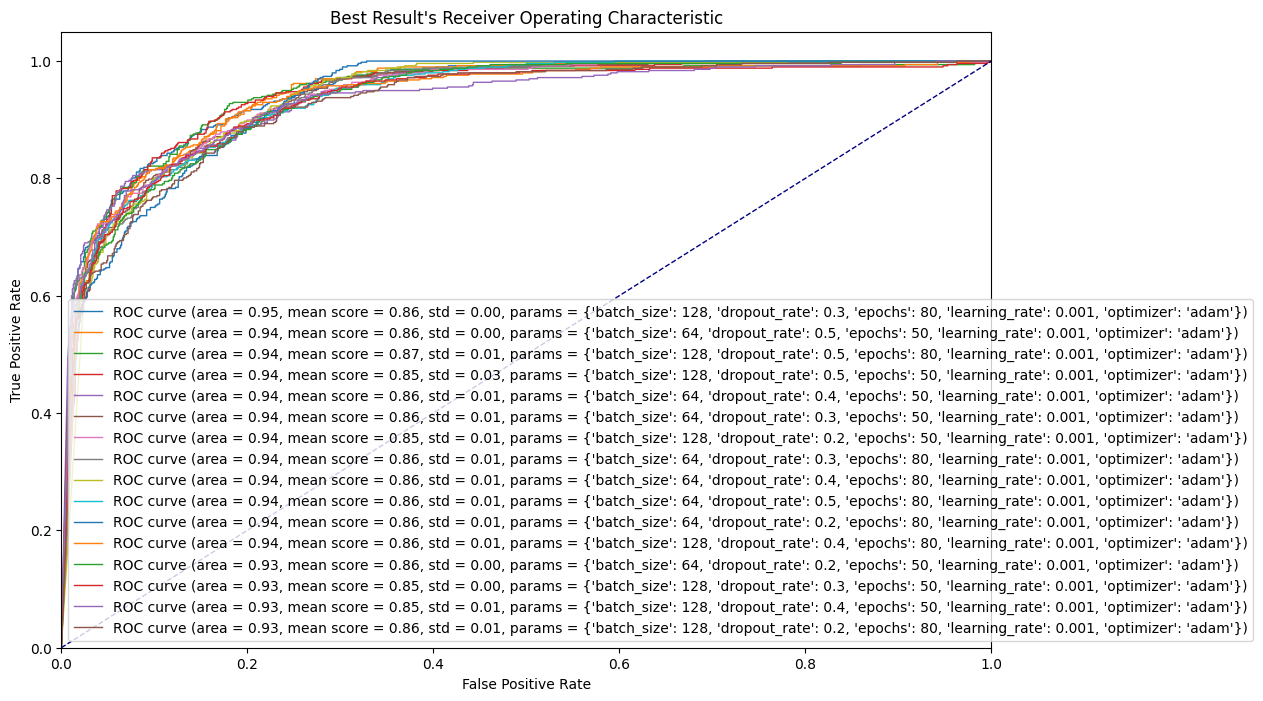

In [8]:
plt.figure(figsize=(12,8))

# Loop through the sorted results
for _, result in sorted_results:
    # Plot the ROC curve
    plt.plot(result['fpr'], result['tpr'], lw=1, label=f'ROC curve (area = {result["roc_auc"]:.2f}, mean score = {result["mean_score"]:.2f}, std = {result["std_score"]:.2f}, params = {result["params"]})')

# Add details to the plot
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Best Result's Receiver Operating Characteristic")
plt.legend(loc="best")
plt.show()


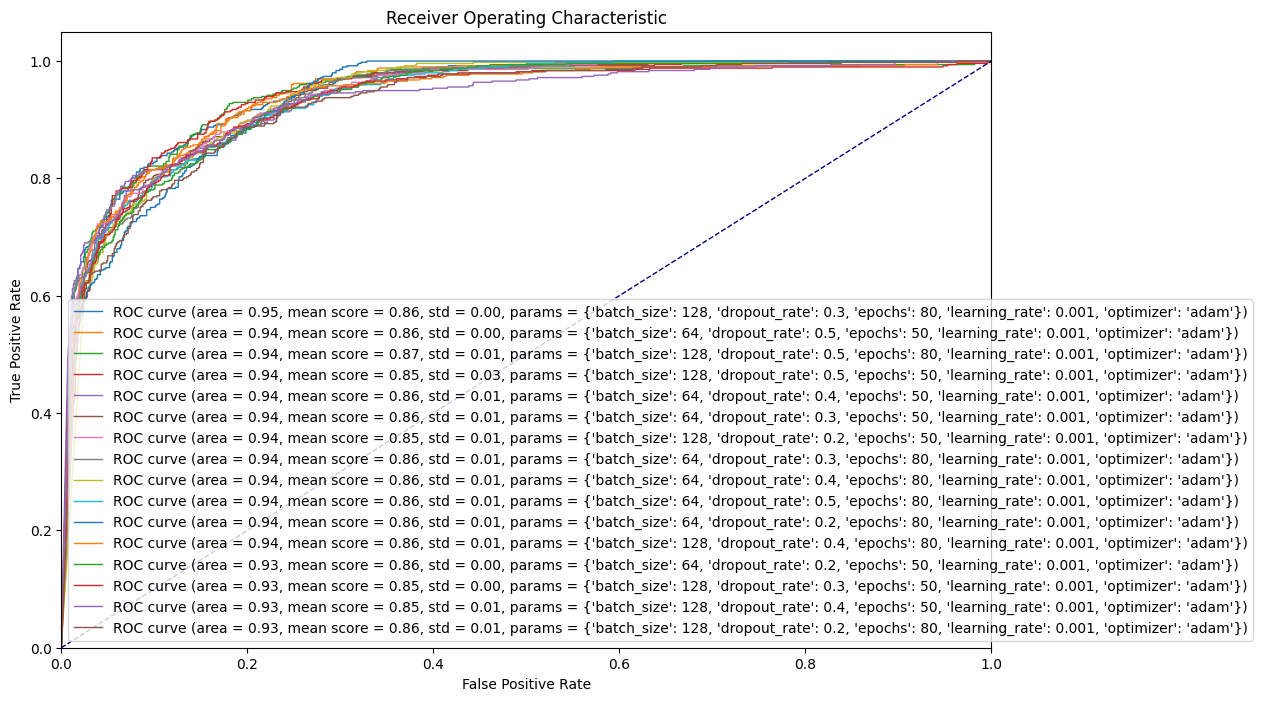

In [9]:
plt.figure(figsize=(12,8))

# Loop through the sorted results
for _, result in sorted_results:
    # Plot the ROC curve
    plt.plot(result['fpr'], result['tpr'], lw=1, label=f'ROC curve (area = {result["roc_auc"]:.2f}, mean score = {result["mean_score"]:.2f}, std = {result["std_score"]:.2f}, params = {result["params"]})')

# Add details to the plot
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.show()
